## Carbon capture on MOFs with quantum chemistry on hardware

We evaluate VQE on the real hardware for $CO_2 @ Mn(II)$ system. We use [pennylane](https://pennylane.ai/) for this purpose and it has [pennylane-braket-plugin](https://amazon-braket-pennylane-plugin-python.readthedocs.io/en/latest/). Specifically, [Rigetti — Aspen-M-3](https://qcs.rigetti.com/qpus) device which is based on superconducting qubits. The device contains 79 qubits but here we only use 4.

In [1]:
import pickle 
import pennylane as qml
import pennylane.numpy as np
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

## Hamiltonian construction

We can use pennylane for constructing the hamiltonian of the system. However, since we earlier used Qiskit for this purpose, we save the hamiltonian in a pickle file and now load it here. This is important for consistency in the results obtained.

In [12]:
with open('co2_mn_hamiltonian.pickle', 'rb') as handle:
    h_dict = pickle.load(handle)

In [13]:
ops = []

for op in h_dict['ops']:
    ops.append(qml.pauli.string_to_pauli_word(op))

coeffs = []
for coeff in h_dict['coeffs']:
    coeffs.append(coeff)

In [14]:
H = qml.Hamiltonian(coeffs, ops)

In case of simulations, we were able to obtain the precise expectation values of our Hamiltonians with just one evaluation per Hamiltonian. This is based on the simulator having access to the precise state and is not feasible if the device, like in the case of a QPU, estimates the expectation with shots.

Let's say we wish to use a limited number of shots to estimate the anticipated value of the electronic Hamiltonian h. There are 100 distinct observables that make up this Hamiltonian are all tensor products of Pauli operators:

In [15]:
print("Number of Pauli terms in h:", len(H.ops))

Number of Pauli terms in h: 100


Running the circuit 100 times while measuring one of the Pauli terms that make up the Hamiltonian H is an easy way to calculate the expectation value. We can, however, improve our efficiency. The Pauli terms can be divided into groups that share a basis ([PennyLane's grouping module](https://docs.pennylane.ai/en/stable/code/api/pennylane.Hamiltonian.html#pennylane.Hamiltonian.compute_grouping) so they can be measured simultaneously on a single circuit. Qubit-wise commuting observables are the names for the components of each group. One can divide the Hamiltonian H into 25 groups

In [16]:
groups, coeffs = qml.grouping.group_observables(H.ops, H.coeffs)
print("Number of qubit-wise commuting groups:", len(groups))

Number of qubit-wise commuting groups: 25


In practise, this means that we only need to conduct 25 circuits as opposed to 100 individual circuits. As the Hamiltonian's Pauli terms grow in number, this savings may become even more noticeable. The number of terms and qubits can both increase, for instance, by switching to a $CO_2 @ Cu(I)$ system.

The PennyLane/Braket pipeline, provides built-in support for pre-grouping the observables in a Hamiltonian to reduce the number of device executions, saving both runtime and simulation costs when employing distant devices.

We must tell PennyLane to divide each Hamiltonian into qubit-wise commuting groups in order to take use of grouping. To achieve this, we compute the groups and store them with the Hamiltonian; the device will use this data to build the necessary circuits at the appropriate time.

In [17]:
H.compute_grouping()

## Simulation on default.qubit

In [79]:
qubits = 4
dev = qml.device("default.qubit", wires=qubits)

In [6]:
@qml.qnode(dev)
def cost_fn(param):
    qml.BasisState(np.array([1,0,0,1]), wires=range(qubits))
    
    for q in range(qubits):
        qml.RY(param[q][0], q)
    
    for q in range(qubits - 1):
        qml.CNOT((q, q+1))
    
    for q in range(qubits):
        qml.RY(param[q][1], q)
        
    return qml.expval(H)

In [102]:
# Define a simple callback function
exact_energy = -663.889337946367
intermediate_info = []
five_percent = []
one_percent = []

def callback(value):
    intermediate_info.append(value)
    five_percent.append(exact_energy*(1-0.05))
    one_percent.append(exact_energy*(1-0.01))
    clear_output(wait=True)
    plt.plot(intermediate_info, color='purple', lw=2, label=f'Simulated VQE {np.round(value,4)}')
    plt.ylabel('Energy')
    plt.xlabel('Iterations')
    # Exact ground state energy value
    plt.axhline(y=exact_energy,color="tab:red",ls="--", lw=2,label="Target: "+str(np.round(exact_energy,4)))
    plt.plot(five_percent, lw=1, label=f'5% ({np.round(exact_energy*(1-0.05),4)})')
    plt.plot(one_percent, lw=1, label=f'1% ({np.round(exact_energy*(1-0.01),4)})')
    plt.legend()
    plt.grid()
    plt.show()

In [7]:
def rel_err(target, measured):
    return abs((target - measured) / target)

In [9]:
max_iterations = 100

In [10]:
opt = qml.SPSAOptimizer(maxiter=max_iterations,a = 0.01, c = 0.01, A = 1)
theta = np.array(np.random.uniform(size=(4,2)), requires_grad=True)

In [11]:
print(qml.draw(cost_fn)(theta))

0: ─╭BasisState(M0)──RY(0.79)─╭●──RY(0.12)─────────────────────┤ ╭<𝓗>
1: ─├BasisState(M0)──RY(0.29)─╰X─╭●─────────RY(0.45)───────────┤ ├<𝓗>
2: ─├BasisState(M0)──RY(0.49)────╰X────────╭●─────────RY(0.62)─┤ ├<𝓗>
3: ─╰BasisState(M0)──RY(0.49)──────────────╰X─────────RY(0.18)─┤ ╰<𝓗>


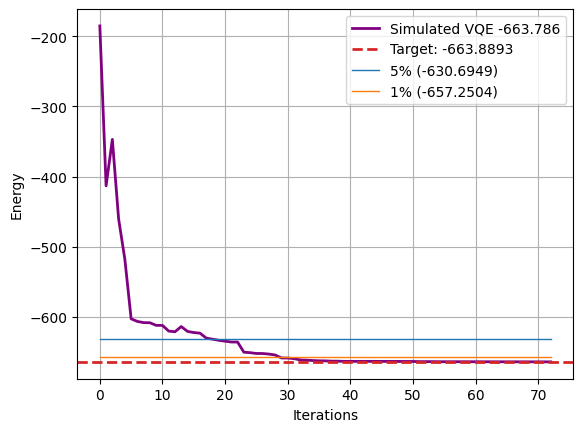


Final value of the ground-state energy = -663.78595851 Ha


In [12]:
# store the values of the cost function
energy = [cost_fn(theta)]

conv_tol = 1e-06

for n in range(max_iterations):
    theta, prev_energy = opt.step_and_cost(cost_fn, theta)
    callback(prev_energy)
    energy.append(cost_fn(theta))
    conv = np.abs(energy[-1] - prev_energy)
    if conv <= conv_tol:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")

In [13]:
# Compute the relative error between the expected ground state energy and the VQE's output
rel_error = rel_err(exact_energy, energy[-1])

print(f'Expected ground state energy: {exact_energy:.12f}')
print(f'Computed ground state energy: {energy[-1]:.12f}')
print(f'Relative error: {rel_error:.12f}')

Expected ground state energy: -663.889337946367
Computed ground state energy: -663.785958512596
Relative error: 0.000155717870


In [14]:
theta

tensor([[ 3.13989173e+00,  3.17094995e+00],
        [-5.11134035e-03,  6.08141512e-04],
        [-2.96957340e+00, -2.89290088e+00],
        [ 1.58228320e+00, -1.57441049e+00]], requires_grad=True)

### Deparameterisation

Some of the parameters are in the vicinity of $0, ± \pi/2$ or $±\pi$. We freeze these parameters and now we are left with only 2 parameters to optimize for.

In [80]:
def cost_fn_deparam(param):
    qml.BasisState(np.array([1,0,0,1]), wires=range(qubits))
    
    qml.RY(np.pi, 0)
    qml.RY(0.0, 1)
    qml.RY(param[0], 2)
    qml.RY(np.pi/2, 3)
    
    for q in range(qubits - 1):
        qml.CNOT((q, q+1))
    
    qml.RY(np.pi, 0)
    qml.RY(0.0, 1)
    qml.RY(param[1], 2)
    qml.RY(-np.pi/2, 3)
        
    return qml.expval(H)

In [87]:
dev = qml.device('default.qubit', wires = qubits)
cost_fn_deparam_local = qml.QNode(cost_fn_deparam, device = dev, diff_method = 'parameter-shift')
cost_fn_deparam_local

<QNode: wires=4, device='default.qubit', interface='autograd', diff_method='parameter-shift'>

In [88]:
max_iterations = 3
opt = qml.SPSAOptimizer(maxiter=max_iterations,a = 0.01, c = 0.01, A = 1)

initial_point = [-2.96957340, -2.89290088]
theta_deparam = np.array(initial_point, requires_grad=True)

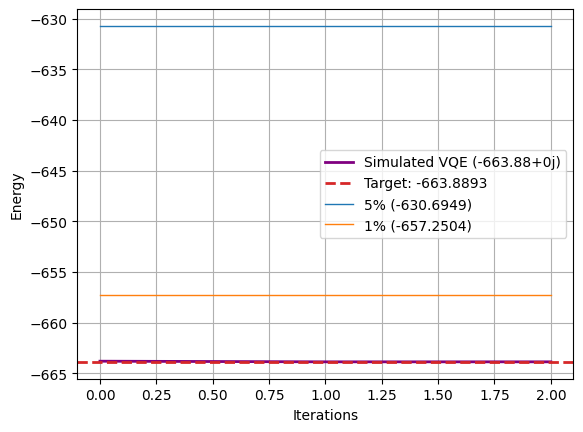


Final value of the ground-state energy = -663.880022937364 Ha


In [89]:
# store the values of the cost function
for n in range(max_iterations):
    theta_deparam, prev_energy = opt.step_and_cost(cost_fn_deparam_local, theta_deparam)
    callback(prev_energy)

computed_energy = prev_energy.real
print("\n" f"Final value of the ground-state energy = {computed_energy:.12f} Ha")

In [90]:
# Compute the relative error between the expected ground state energy and the VQE's output
rel_error = rel_err(exact_energy, computed_energy)

print(f'Expected ground state energy: {exact_energy:.12f}')
print(f'Computed ground state energy: {computed_energy:.12f}')
print(f'Relative error: {rel_error:.12f}')

Expected ground state energy: -663.889337946367
Computed ground state energy: -663.880022937364
Relative error: 0.000014030966


## Simulation on Braket SDK's local simulator

We simulate the circuit of 4 qubits on Braket's local simulator for 100 iterations with SPSA optimizer. The Hartree-fock state is $|1001>$. 

In [97]:
dev = qml.device("braket.local.qubit", wires=qubits, shots=1000)
cost_fn_braket_local = qml.QNode(cost_fn_deparam, device=dev, diff_method = 'parameter-shift')
cost_fn_braket_local

<QNode: wires=4, device='braket.local.qubit', interface='autograd', diff_method='parameter-shift'>

In [98]:
max_iterations = 3
opt = qml.SPSAOptimizer(maxiter=max_iterations,a = 0.01, c = 0.01, A = 1)

initial_point = [-2.96957340, -2.89290088]
theta_deparam = np.array(initial_point, requires_grad=True)

In [99]:
theta_deparam

tensor([-2.9695734 , -2.89290088], requires_grad=True)

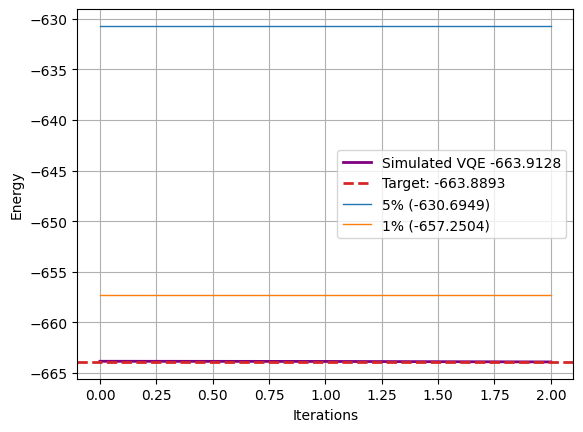


Final value of the ground-state energy = -663.912845858715 Ha


In [100]:
# store the values of the cost function
for n in range(max_iterations):
    theta_deparam, prev_energy = opt.step_and_cost(cost_fn_braket_local, theta_deparam.real)
    print(theta_deparam)
    callback(prev_energy.real)

computed_energy = prev_energy.real
print("\n" f"Final value of the ground-state energy = {computed_energy:.12f} Ha")

In [101]:
# Compute the relative error between the expected ground state energy and the VQE's output
rel_error = rel_err(exact_energy, computed_energy)

print(f'Expected ground state energy: {exact_energy:.12f}')
print(f'Computed ground state energy: {computed_energy:.12f}')
print(f'Relative error: {rel_error:.12f}')

Expected ground state energy: -663.889337946367
Computed ground state energy: -663.912845858715
Relative error: 0.000035409384


## Results

The algorithm sucessufully converges to the `computed part energy` with a relative error of `0.000035409384` that is within $10^{-4}$ Hartree.

The relative error of `VQE's ground state energy` with the `classical reference solution` is `0.007414909` which is within $10^{-2}$.

## The Remote Braket device

PennyLane-Braket plugin's remote device uses Amazon Braket's remote service to do quantum computations. A high-performance simulator backend and hardware vendors are accessible through the remote service.

We use the deparameterised circuit and only run for 3 iterations with SPSA optimizer.

In [103]:
device_arn = 'arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3'

In [104]:
dev = qml.device('braket.aws.qubit', device_arn=device_arn, wires=qubits)
cost_fn_braket_remote = qml.QNode(cost_fn_deparam, device=dev, diff_method = 'parameter-shift')

In [105]:
cost_fn_braket_remote

<QNode: wires=4, device='braket.aws.qubit', interface='autograd', diff_method='parameter-shift'>

In [106]:
max_iterations = 3
opt = qml.SPSAOptimizer(maxiter=max_iterations,a = 0.01, c = 0.01, A = 1)

initial_point = [-2.96957340, -2.89290088]
theta_deparam = np.array(initial_point, requires_grad=True)

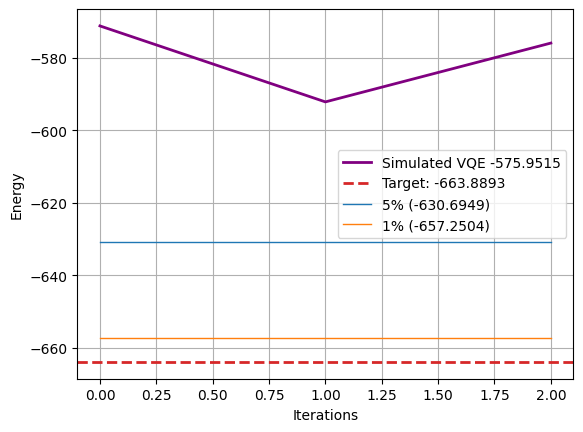


Final value of the ground-state energy = -575.951487075476 Ha


In [107]:
# store the values of the cost function
for n in range(max_iterations):
    theta_deparam, prev_energy = opt.step_and_cost(cost_fn_braket_remote, theta_deparam.real)
    callback(prev_energy.real)

computed_energy = prev_energy.real
print("\n" f"Final value of the ground-state energy = {computed_energy:.12f} Ha")

In [109]:
# Compute the relative error between the expected ground state energy and the VQE's output
rel_error = rel_err(exact_energy, computed_energy)

print(f'Expected ground state energy: {exact_energy:.12f}')
print(f'Computed ground state energy: {computed_energy:.12f}')
print(f'Relative error: {rel_error:.12f}')

Expected ground state energy: -663.889337946367
Computed ground state energy: -575.951487075476
Relative error: 0.132458597909


## Results

The algorithm halted with a relative error of `0.132458597909`. Unsuprisingly, the result has a very high relative error and needs more iterations to converge successfully to the ground state (which is costly and time consuming).

The relative error of `VQE's ground state energy` with the `classical reference solution` is 0.073176587 which is within  $10{−1}$ (`7.3 percent`).

## Conclusion

We investigated the minimum of the Potential Energy Surface (PES) based on the recent paper [*Molecular Energy Landscapes of Hardware-Efficient Ansätze* in Quantum Computing by Boy Choy and David J. Wales](https://pubs.acs.org/doi/pdf/10.1021/acs.jctc.2c01057), We used Hardware-efficient ansatz with varying depths for $BeH_2$ molecule using the VQE algorithm. We used a deparameterisation approach to freeze $R_y$ gates with standardized parameter values which helped in simplifying the energy landscape while maintaining the accuracy of the global minimum. For $BeH_2$, deparameterisation significantly reduced the number of trainable parameters while retaining the accuracy of ground state energy.

We extended the deparameterisation procdeure to carbon capture on MOFs and explored the minimum of PES with $CO_2$ with 2 metal ions $Mn(II)$ and $Cu(I)$ which led to interesting results. For both the systems, we were able to reduce the parameters to 2 from 8 and 10 for the ansatz of $Mn(II)$ and $Cu(I)$ respectively. We simulated our ansatzes on noisy simulators as well as Braket's remote devices and obtained promising results. We employed error mitigation techniques in noisy simulators which converged the ground state energy to within 6 percent of the acutal.

It is an exciting idea to employ quantum computing to profile molecular energy landscapes, and we intend to apply the techniques used here to investigate problem inspired circuit ansatzes and compare them with hardware-efficient ansatzes in subsequent work.

## References

1. [Proximo Weekly: Direct air capture – direct to market?](https://www.proximoinfra.com/articles/8105/Proximo-Weekly-Direct-air-capture-direct-to-market)
2. [Molecular Energy Landscapes of Hardware-Efficient Ansätze in Quantum Computing](https://pubs.acs.org/doi/pdf/10.1021/acs.jctc.2c01057)
3. [Modelling carbon capture on metal-organic frameworks with quantum computing](https://link.springer.com/content/pdf/10.1140/epjqt/s40507-022-00155-w)
4. [Amazon braket examples: Hydrogen Molecule geometry with VQE](https://github.com/aws/amazon-braket-examples/blob/main/examples/pennylane/3_Hydrogen_Molecule_geometry_with_VQE/3_Hydrogen_Molecule_geometry_with_VQE.ipynb)